<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/Mass%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eagleSqlTools
!pip install colossus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 3.9 MB/s 


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
from colossus.cosmology import cosmology
from colossus.lss import mass_function

con = sql.connect("vwg533", password = "FZtn087h")

In [3]:
cosmology.setCosmology('WMAP9')
mfunc_fof = mass_function.massFunction(1E12, 0.0, mdef = 'fof', model = 'watson13')

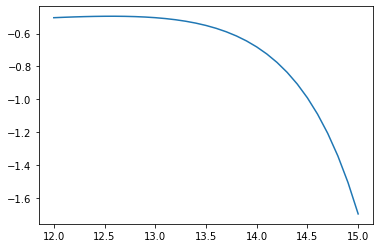

In [5]:
powers = np.arange(12,15.1, 0.1)
masses = 10**powers
mfunc = []

for i in range (len(masses)):
  mfunc = mfunc + [mass_function.massFunction(masses[i], 0.0, mdef = 'vir', model = 'tinker08')]

plt.figure()

plt.plot(np.log10(masses), np.log10(mfunc))

plt.show()